In [461]:
import mne
from mne.preprocessing import ICA


import mtrf
from mtrf.model import TRF
import eelbrain as eel

import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.io import wavfile, loadmat, savemat
from scipy.signal import hilbert

import librosa
import librosa.display
import mido

import sys
sys.path.append('../utils')
from pp_utils import *
from plot_utils import *
from mTRF_utils import *
from midi_utils import *

import pickle


## PREPARING DATA AND STIMULI

Parameters

In [462]:
#subjects_to_process = ['01', '04', '05']
subject = '05'
period = 'pre'

with open('../utils/ch_names.pkl', 'rb') as file:
    ch_names_all = pickle.load(file)
ch_names_64 = ch_names_all[0:64]
ch_names_72 = ch_names_all[0:72]


Loading EEG data

In [463]:
#directories
eeg_path = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/data_preprocessed/{subject}/eeg_listen_{period}_{subject}.mat'
mTRF_path = '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_mTRF_data'

#LOAD PREPROCESSED DATA
data = loadmat(eeg_path)
#eeg = data['trial_data']
events_sv = data['events']
all_electrodes = data['all_electrodes']
#
# eeg = eeg.T #because first dimension has to be time
fs = 128


#making raw object from .mat data
info = mne.create_info(ch_names=ch_names_72, sfreq = 128, ch_types='misc')
raw = mne.io.RawArray(all_electrodes, info = info)

#define channel types
raw.set_channel_types({name: 'eeg' for name in ch_names_72[0:64]})
raw.set_channel_types({name: 'eog' for name in ch_names_72[66:68]})


Creating RawArray with float64 data, n_channels=72, n_times=85120
    Range : 0 ... 85119 =      0.000 ...   664.992 secs
Ready.


/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_17469/4147775037.py:20: RuntimeWarning: The unit for channel(s) AF3, AF4, AF7, AF8, AFz, C1, C2, C3, C4, C5, C6, CP1, CP2, CP3, CP4, CP5, CP6, CPz, Cz, F1, F2, F3, F4, F5, F6, F7, F8, FC1, FC2, FC3, FC4, FC5, FC6, FCz, FT7, FT8, Fp1, Fp2, Fpz, Fz, Iz, O1, O2, Oz, P1, P10, P2, P3, P4, P5, P6, P7, P8, P9, PO3, PO4, PO7, PO8, POz, Pz, T7, T8, TP7, TP8 has changed from NA to V.
  raw.set_channel_types({name: 'eeg' for name in ch_names_72[0:64]})
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_17469/4147775037.py:21: RuntimeWarning: The unit for channel(s) LO1, LO2 has changed from NA to V.
  raw.set_channel_types({name: 'eog' for name in ch_names_72[66:68]})


<RawArray | 72 x 85120 (665.0 s), ~46.8 MB, data loaded>

In [464]:
#ICA on EEG data to remove eyeblinks
ica = ICA(max_iter="auto", random_state=97)
ica.fit(raw)

#exclude components
eog_indices, eog_scores = ica.find_bads_eog(raw)

ica.exclude = eog_indices
reconst_raw = raw.copy()
ica.apply(reconst_raw)

print('Excluded components', eog_indices)

#define eeg matrix
eeg = reconst_raw.get_data()[0:64].T

Fitting ICA to data using 64 channels (please be patient, this may take a while)


/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_17469/1345725598.py:3: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by non-zero PCA components: 64 components
Fitting ICA took 26.7s.
Using EOG channels: LO1, LO2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 sam

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


    Transforming to ICA space (64 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components
Excluded components [0, 11]


Loading stimuli

In [465]:
#loading onset times
events_arr = make_raw_events(events_sv)
events_keystrokes = clean_triggers(events_arr[events_arr[:, 2]==2])
onset_indices = events_keystrokes[:,0]

onsets_sv = np.zeros_like(events_sv[0])
onsets_sv[onset_indices] = 1

In [466]:
#loading midi values 

numcycles = 2
exampleset = midi_target('/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/stimuli/passive listening.mid')
fullset = exampleset * numcycles

#flatten list
midi_values = [x for xs in fullset for x in xs]

#translate to normalized pitch height
midi_pitch_mapping = {60: 1, 59: 2, 57: 3, 55: 4, 53: 5}
pitch_height = []
for x in midi_values: 
    pitch_height.append(midi_pitch_mapping[x])

#make support vector
index_midi = 0
midi_sv  = []
for num in onsets_sv:
    if num == 1:
        midi_sv.append(pitch_height[index_midi])
        index_midi += 1
    else:
        midi_sv.append(num)
midi_sv = np.array(midi_sv)

#concatenating all factors
midi_onsets_sv = np.vstack([onsets_sv, midi_sv]).T

In [467]:
#defining cross-validation segments 
n_segments = 20

eeg_segments = segment(eeg, n_segments)
onset_segments = segment(onsets_sv, n_segments)
midi_segments = segment(midi_sv, n_segments)
midi_onsets_segments = segment(midi_onsets_sv, n_segments) #segment not working here because of shape?

In [468]:
#loading some bogus shuffled stimuli
num_onsets = np.count_nonzero(onsets_sv)
shuf_onsets = np.zeros_like(onsets_sv)
shuf_indices = np.random.randint(0,onsets_sv.shape[0], size = num_onsets)
shuf_onsets[shuf_indices] = 1
shuf_onsets_segments = segment(shuf_onsets, n_segments)

## TRAIN TRF

In [476]:
stimulus = midi_onsets_segments


fwd_trf = TRF(direction=1)
tmin, tmax =-0.1, 0.3  # range of time lag
regularization = 1 # regularization parameter lambda, originally 1000
fwd_trf.train(stimulus, eeg_segments, fs, tmin, tmax, regularization)

prediction, r_fwd = fwd_trf.predict(stimulus, eeg_segments)

print(f"correlation between actual and predicted response: {r_fwd.round(3)}")


correlation between actual and predicted response: 0.089


In [477]:
from mtrf.stats import crossval
r_fwd = crossval(fwd_trf, stimulus, eeg_segments, fs, tmin, tmax, regularization)
print(f"Mean correlation between actual and predicted response: {r_fwd.mean().round(3)}")
print('Covariance = ', r_fwd**2)

Cross-validating[##################################################] 10/10

Mean correlation between actual and predicted response: 0.075
Covariance =  0.005609504026172624


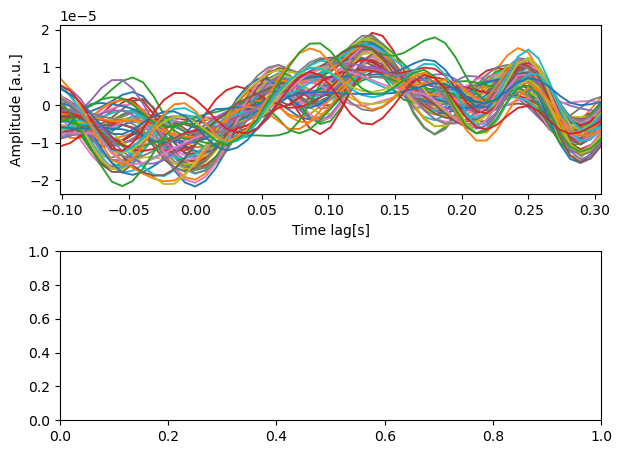

In [471]:

fig, ax = plt.subplots(2)
plt.tight_layout(pad = 2)
fwd_trf.plot(feature=0, axes=ax[0], show=True)
#fwd_trf.plot(channel='gfp', axes=ax[0], kind='image', show=False)

plt.show()

No projector specified for this dataset. Please consider the method self.add_proj.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


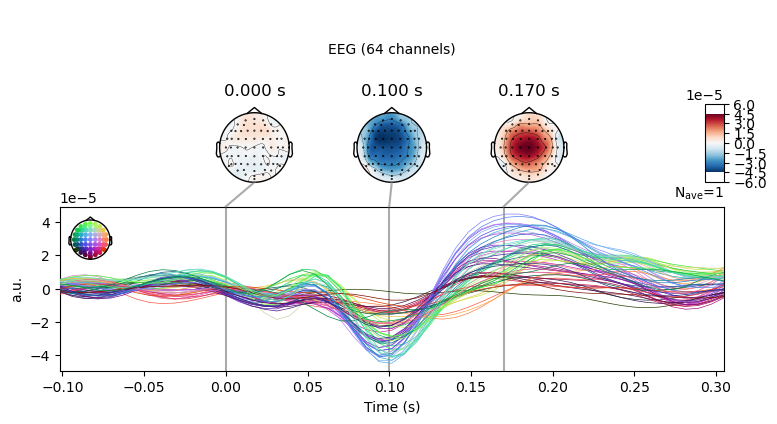

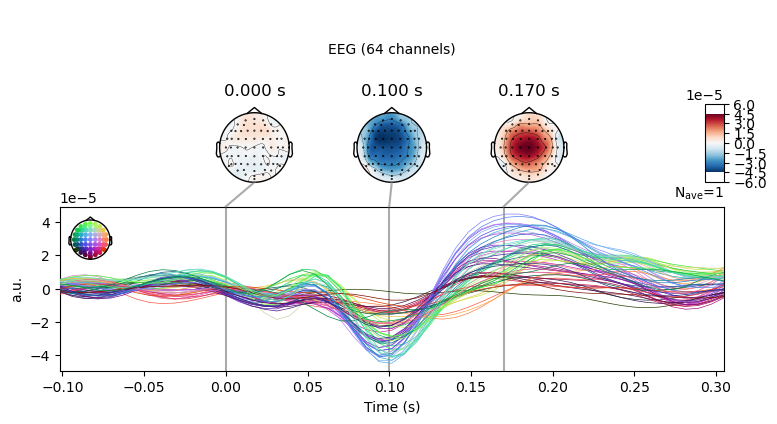

In [478]:
from mne.channels import make_standard_montage

# use standard montage for the EEG system used for recording the response
montage = make_standard_montage('biosemi64')
evokeds = fwd_trf.to_mne_evoked(montage)
evokeds[0].plot_joint([0, 0.1, 0.17], topomap_args={"scalings": 1}, ts_args={"units": "a.u.", "scalings": dict(eeg=1)})

In [473]:
fwd_trf.weights.shape

(1, 53, 64)

Save data

In [474]:
savemat(f'{mTRF_path}listen_{period}_{subject}.mat', {'weights': fwd_trf.weights, 'r': r_fwd})

## A BIG MESS BELOW

Envelope extraction from audio file (extraction of dubious quality)

In [475]:
"""#utils 

#envelope extraction using scipy
def extract_envelope(file, fs = 128):
    sample_rate, data = wavfile.read(file)
    
    # Convert to mono if the audio is stereo
    if len(data.shape) > 1:
        data = np.mean(data, axis=1)
        target_samples = int(len(data) * fs / sample_rate)
        data = scipy.signal.resample(data, target_samples)

    analytic_signal = hilbert(data)
    envelope = np.abs(analytic_signal)
    
    return sample_rate, envelope

def moving_average(signal, window_size):
    """
   """ Smooths a 1D signal using a moving average filter.

    Parameters:
        signal (list or numpy array): The input 1D signal.
        window_size (int): The size of the moving window.

    Returns:
        smoothed_signal (numpy array): The smoothed signal."""
    """

    if window_size % 2 == 0:
        raise ValueError("Window size must be odd.")

    # Pad the signal to handle edges
    padding = window_size // 2
    padded_signal = np.pad(signal, (padding, padding), mode='edge')

    # Apply the moving average filter
    weights = np.ones(window_size) / window_size
    smoothed_signal = np.convolve(padded_signal, weights, mode='valid')

    return smoothed_signal

def segment(arr, n_segments):
    segment_size = len(arr) // n_segments  # Calculate the size of each segment
    segments = [arr[i * segment_size : (i + 1) * segment_size] for i in range(10)]  # Slice the array into 10 segments
    return segments
"""

IndentationError: unexpected indent (1349379272.py, line 20)

In [ ]:
#sample_rate, envelope = extract_envelope(stimfile)

In [ ]:
"""#trim eeg to length of env
eeg = eeg[0:envelope.shape[0]]
times = np.linspace(0, eeg.shape[0]/fs, eeg.shape[0])
"""

Text(0, 0.5, 'Envelope (a.u.)')

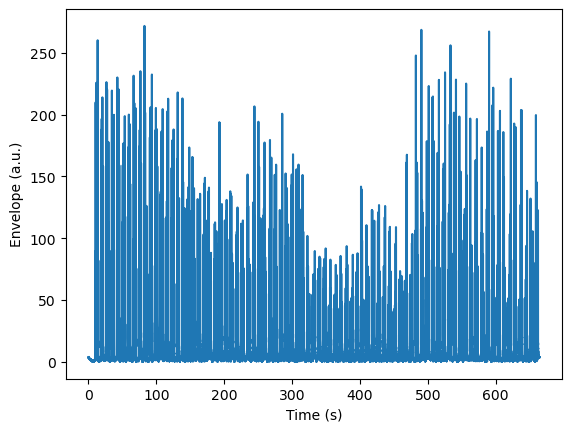

In [ ]:
"""plt.plot(times, envelope)
plt.xlabel('Time (s)')
plt.ylabel('Envelope (a.u.)')"""

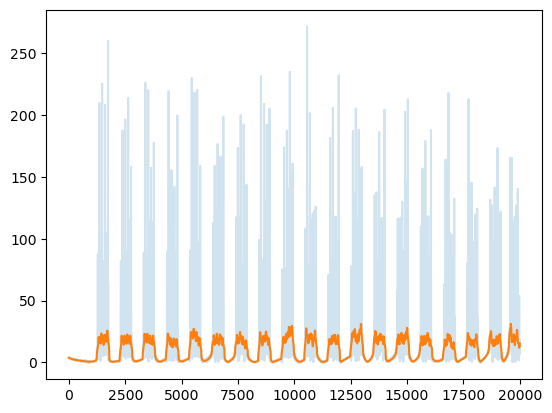

In [ ]:
"""env_smoothed = moving_average(envelope, 101)
plt.plot(envelope[0:20000], alpha = 0.2)
plt.plot(env_smoothed[0:20000])
#plt.ylim(0,10)"""

In [ ]:
"""
env_segments = segment(env_smoothed, 10)
eeg_segments = segment(eeg,10)
"""

In [ ]:
"""n_timepoints = int(env_segments[0].shape[0])
list_noise = []
while len(list_noise) < 10:
    noise = np.random.rand(n_timepoints)*100

    list_noise.append(noise)
list_noise"""

In [ ]:
"""fwd_trf = TRF(direction=1)
tmin, tmax =-0.1, 0.3  # range of time lag
regularization = 1000 # regularization parameter lambda
fwd_trf.train(env_segments, eeg_segments, fs, tmin, tmax, regularization)"""

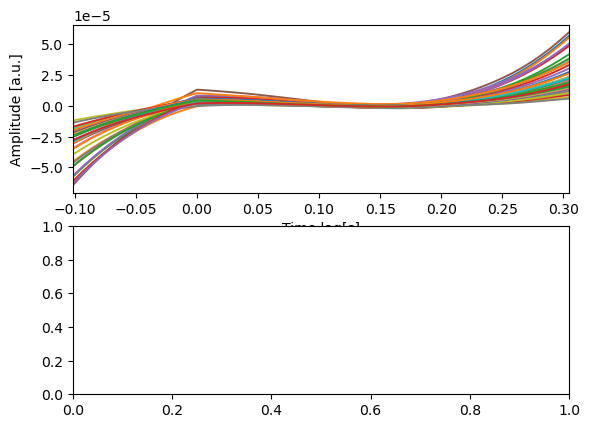

<Figure size 640x480 with 0 Axes>

In [ ]:
"""
fig, ax = plt.subplots(2)
fwd_trf.plot(feature=400, axes=ax[0], show=True)
#fwd_trf.plot(channel='avg', axes=ax[1], kind='image', show=False)
plt.tight_layout()
plt.show()"""

In [ ]:
"""from mtrf.model import load_sample_data

stimulus, response, fs = load_sample_data(n_segments=10, normalize=True)
"""

In [ ]:
"""from mtrf.model import TRF

fwd_trf = TRF(direction=1)
tmin, tmax = 0, 0.4  # range of time lag
regularization = 1000 # regularization parameter lambda
fwd_trf.train(stimulus, response, fs, tmin, tmax, regularization)"""

In [ ]:
"""

# Load the audio file
#file_path = 'your_audio_file.wav'
y, sr = librosa.load(stimfile)

# Perform onset detection
onset_frames = librosa.onset.onset_detect(y=y, sr=sr)
"""

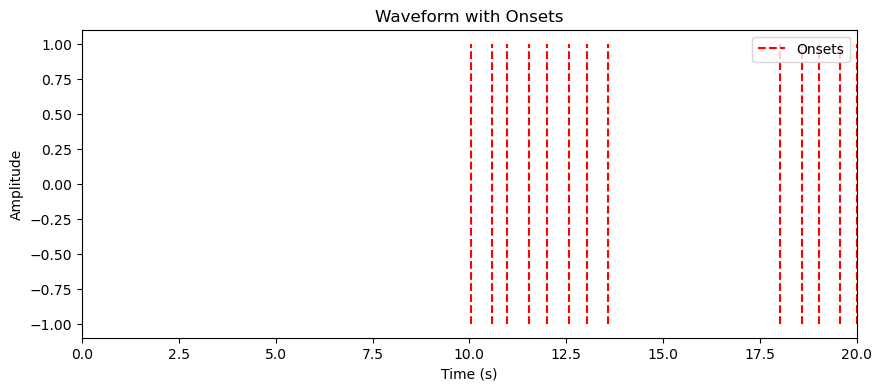

Detected onset times (seconds): [ 10.03102041  10.58829932  10.98303855  11.54031746  12.00471655
  12.56199546  13.02639456  13.58367347  18.01868481  18.57596372
  19.01714286  19.55120181  19.99238095  20.54965986  21.01405896
  21.54811791  25.9599093   26.51718821  26.93514739  27.4924263
  27.91038549  28.4676644   28.90884354  29.46612245  34.01723356
  34.57451247  35.01569161  35.57297052  36.01414966  36.57142857
  37.05904762  37.59310658  42.05133787  42.60861678  42.98013605
  43.53741497  43.9321542   44.46621315  44.9538322   45.51111111
  49.99256236  50.54984127  50.99102041  51.54829932  51.98947846
  52.54675737  52.98793651  53.52199546  58.02666667  58.58394558
  59.00190476  59.55918367  60.04680272  60.58086168  61.02204082
  61.57931973  66.01433107  66.57160998  67.08244898  67.61650794
  68.01124717  68.56852608  68.98648526  69.54376417  74.02521542
  74.58249433  75.00045351  75.55773243  76.02213152  76.57941043
  76.97414966  77.53142857  81.98965986  82.5

In [ ]:
"""# Plot the waveform and onsets
plt.figure(figsize=(10, 4))
#librosa.display.waveshow(y, sr=sr, alpha=0.5)
plt.vlines(onset_times, -1, 1, color='r', linestyle='--', label='Onsets')
plt.xlabel('Time (s)')
plt.xlim(0,20)
plt.ylabel('Amplitude')
plt.title('Waveform with Onsets')
plt.legend()
plt.show()

# Print detected onset times
print("Detected onset times (seconds):", onset_times)"""

## LIBROSA ONSETS

In [ ]:
"""# Load the audio file
y, sr = librosa.load(stimfile, mono=True)  # Load with original sampling rate and keep stereo if present
target_sr = 128

y_resampled = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
y_resampled_normalized = librosa.util.normalize(y_resampled)"""

In [ ]:
"""o_env = librosa.onset.onset_strength(y=y, sr=sr)
times = librosa.times_like(o_env, sr=sr)
onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sr, hop_length=25)"""

In [ ]:
"""
onset_times = librosa.onset.onset_detect(y= y, sr=sr, hop_length=40, units='time')
onset_times"""

array([ 10.01723356,  10.56326531,  10.97505669,  11.51927438,
        11.99818594,  12.54421769,  13.01950113,  13.56553288,
        18.00816327,  18.55238095,  18.99863946,  19.5446712 ,
        19.98548753,  20.53151927,  20.98866213,  21.53650794,
        25.95011338,  26.49614512,  26.92426304,  27.47029478,
        27.90385488,  28.44988662,  28.89251701,  29.44036281,
        34.00997732,  34.55600907,  35.00408163,  35.55011338,
        36.00544218,  36.55328798,  37.03401361,  37.58004535,
        42.03537415,  42.57959184,  42.96780045,  43.51564626,
        43.91292517,  44.45895692,  44.93605442,  45.48390023,
        49.98095238,  50.52879819,  50.98231293,  51.53015873,
        51.98185941,  52.52970522,  52.96145125,  53.50748299,
        58.01179138,  58.55782313,  58.98412698,  59.53015873,
        60.02358277,  60.56780045,  61.00861678,  61.55464853,
        66.00090703,  66.54693878,  67.0585034 ,  67.60453515,
        67.99455782,  68.54240363,  68.97414966,  69.51

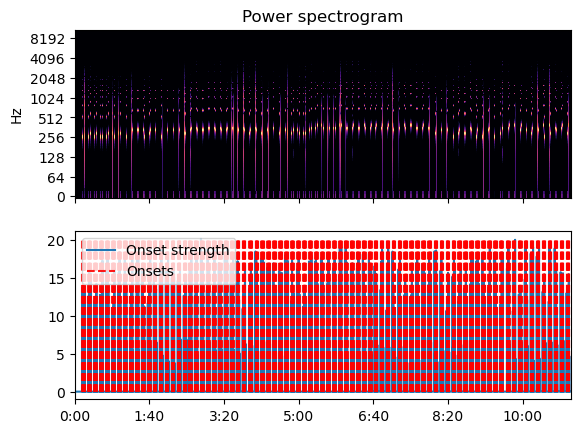

In [ ]:
"""D = np.abs(librosa.stft(y))
fig, ax = plt.subplots(nrows=2, sharex=True)
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),
                         x_axis='time', y_axis='log', ax=ax[0])
ax[0].set(title='Power spectrogram')
ax[0].label_outer()
ax[1].plot(times, o_env, label='Onset strength')
ax[1].vlines(times[onset_frames], 0, o_env.max(), color='r', alpha=0.9,
           linestyle='--', label='Onsets')
ax[1].legend()"""

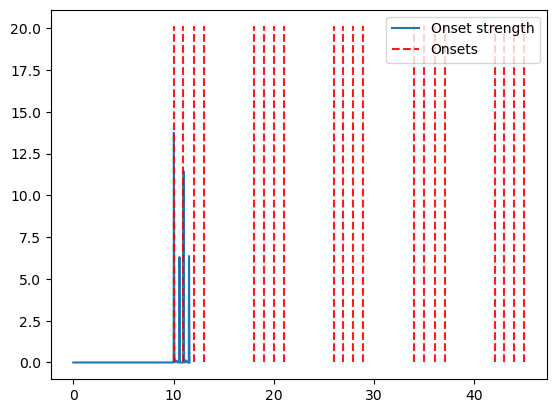

In [ ]:
"""plt.plot(times[0:500], o_env[0:500], label='Onset strength')
plt.vlines(times[onset_frames][0:20], 0, o_env.max(), color='r', alpha=0.9,
           linestyle='--', label='Onsets')
plt.legend()"""